# Load Data

In [ ]:
import os
import pandas as pd
import re  
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import shapiro, levene, zscore

def compute_accuracy_from_files(condition_path, keyword):
    """
    Read all text files in the given path with the specified keyword,
    and compute the accuracy for each file, extracting additional variables
    from the filenames.
    """
    accuracies = []
    for filename in os.listdir(condition_path):
        if filename.endswith('.txt') and keyword in filename:
            file_path = os.path.join(condition_path, filename)
            df = pd.read_csv(file_path)
            
            # Extract mood, fatigue, and sensitivity from the filename
            match = re.search(r'_m(\d+)_f(\d+)_s(\d+)', filename)
            if match:
                mood = int(match.group(1))
                fatigue = int(match.group(2))
                sensitivity = int(match.group(3))
            else:
                mood, fatigue, sensitivity = None, None, None
            
            # Compute accuracy as the proportion of correct guesses
            accuracy = df['Accuracy'].mean()
            
            # Save the accuracy and extracted variables
            accuracies.append({
                'Filename': filename,
                'Accuracy': accuracy,
                'Mood': mood,
                'Fatigue': fatigue,
                'Sensitivity': sensitivity
            })
    return pd.DataFrame(accuracies)

# Define the path to your data directory
data_path = r"C:\Users\jdiaz\Desktop\DTU_ExperimentCognitiveScience\synthetic_data"
# Compute accuracies for both conditions
pleasant_accuracies = compute_accuracy_from_files(data_path, "con1")
neutral_accuracies = compute_accuracy_from_files(data_path, "con0")

# Add condition labels
pleasant_accuracies['Condition'] = 'Pleasant'
neutral_accuracies['Condition'] = 'Neutral'

# Combine both conditions into a single DataFrame
all_accuracies = pd.concat([pleasant_accuracies, neutral_accuracies], ignore_index=True)


# Data Exploration

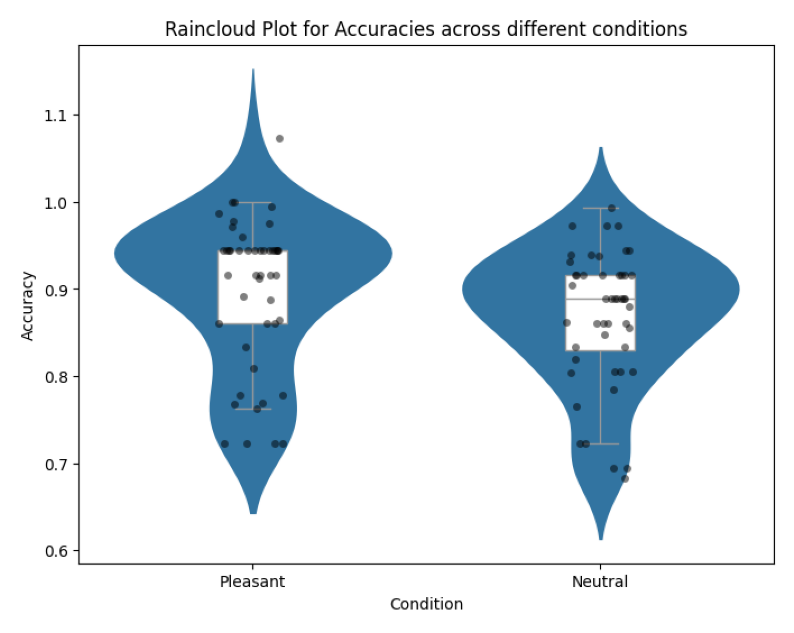

In [8]:
# Create the plot
plt.figure(figsize=(8, 6))

# Create the violin plot (half violins)
sns.violinplot(data=all_accuracies, x='Condition', y='Accuracy', inner=None, linewidth=0)

# Overlay a boxplot
sns.boxplot(data=all_accuracies, x='Condition', y='Accuracy', width=0.2, color='white', fliersize=0)

# Overlay strip plot (dots)
sns.stripplot(data=all_accuracies, x='Condition', y='Accuracy', jitter=True, color='black', alpha=0.5)

plt.title("Raincloud Plot for Accuracies across different conditions")
plt.show()


# Assumptions for Ranked ANCOVA

1. Independence of Observations: done through study design

2. Normality of Residuals

The residuals (differences between observed and predicted values) should be approximately normally distributed.
How to check: This can be assessed using Shapiro-Wilk or Kolmogorov-Smirnov tests for normality.



Shapiro-Wilk Test for residuals: Statistics = 0.9733, p-value = 0.0492


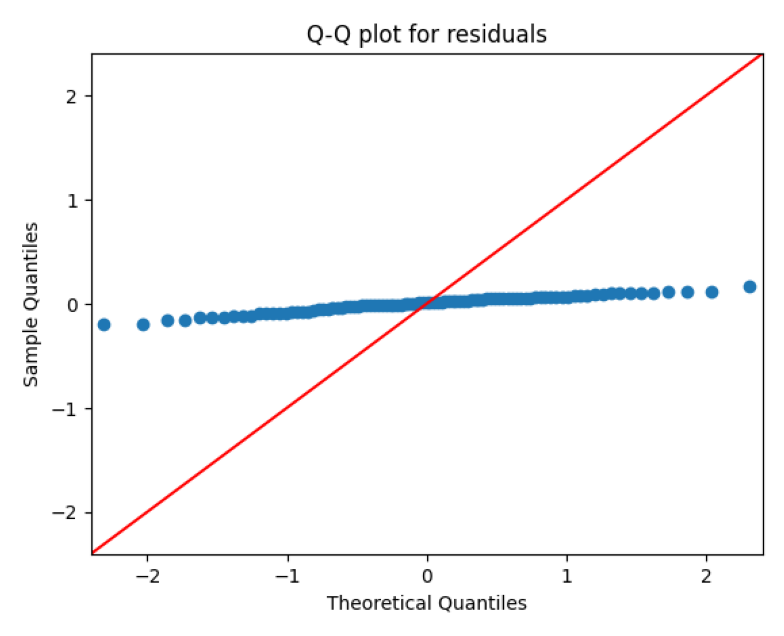

In [10]:
# 1. Normality of Residuals (Shapiro-Wilk Test and Q-Q Plot)
model = smf.ols('Accuracy ~ Condition + Sensitivity + Fatigue + Mood', data=synthetic_data).fit()
residuals = model.resid

# Shapiro-Wilk Test for Normality
shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk Test for residuals: Statistics = {round(shapiro_test[0],4)}, p-value = {round(shapiro_test[1],4)}")

# Q-Q plot
sm.qqplot(residuals, line='45')
plt.title('Q-Q plot for residuals')
plt.show()

3. Homogeneity of Variance (Homogeneity of Covariances for ANCOVA):

This assumption states that the variance of the dependent variable should be roughly equal across all levels of the independent variable (group).
How to check: Use Levene's Test or Bartlett's Test to check if variances are equal across groups.
Levene’s Test is often preferred since it is more robust to non-normal data.

In [11]:
# 3. Homogeneity of Variance (Levene's Test)
# Levene's test checks if variances are equal across groups
levene_test = levene(all_accuracies[synthetic_data['Condition'] == 'Pleasant']['Accuracy'],
                    all_accuracies[synthetic_data['Condition'] == 'Neutral']['Accuracy'])

print(f"Levene's Test for Homogeneity of Variances: Statistics = {round(levene_test[0],4)}, p-value = {round(levene_test[1],4)}")


Levene's Test for Homogeneity of Variances: Statistics = 0.2677, p-value = 0.6061


4. Linearity: Scatter plots for dependent variable vs covariates

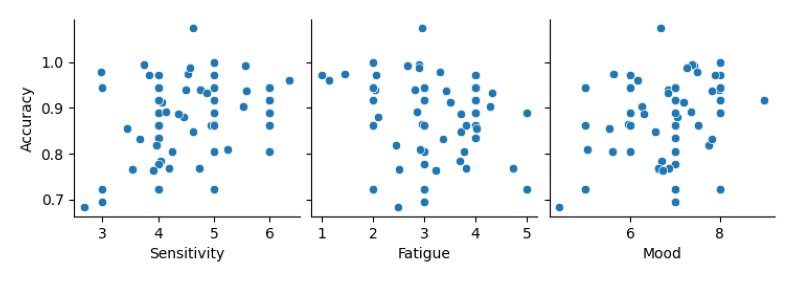

In [13]:
# 4. Scatter plots for dependent variable vs covariates

# Add jitter
def add_jitter(values, jitter_amount=0.2):
    return values + np.random.uniform(-jitter_amount, jitter_amount, size=len(values))

# Apply jitter to the desired columns
all_accuracies["Sensitivity_jittered"] = add_jitter(all_accuracies["Sensitivity"])
all_accuracies["Fatigue_jittered"] = add_jitter(all_accuracies["Fatigue"])
all_accuracies["Mood_jittered"] = add_jitter(all_accuracies["Mood"])

sns.pairplot(all_accuracies, x_vars=["Sensitivity_jittered", "Fatigue_jittered", "Mood_jittered"], y_vars=["Accuracy"])
plt.show()

# Ranked ANCOVA

In [15]:
# Rank the variables (Accuracy, Sensitivity, Fatigue, Mood)
all_accuracies['Accuracy_rank'] = all_accuracies['Accuracy'].rank()
all_accuracies['Sensitivity_rank'] = all_accuracies['Sensitivity'].rank()
all_accuracies['Fatigue_rank'] = all_accuracies['Fatigue'].rank()
all_accuracies['Mood_rank'] = all_accuracies['Mood'].rank()

# Run ANCOVA on the ranks
ancova_ranked = pg.ancova(data=all_accuracies, dv='Accuracy_rank', covar=['Sensitivity_rank', 'Fatigue_rank', 'Mood_rank'], between='Condition')

# Print results of rank-based ANCOVA
print(round(ancova_ranked,2))

             Source        SS  DF     F p-unc   np2
0         Condition   4215.43   1  6.37  0.01  0.07
1  Sensitivity_rank   3167.98   1  4.79  0.03  0.05
2      Fatigue_rank   2347.85   1  3.55  0.06  0.04
3         Mood_rank   2323.08   1  3.51  0.06  0.04
4          Residual  59562.91  90   NaN   NaN   NaN
